# Load the data and upload to HF

In [1]:
!rm -r old-a6000

rm: cannot remove 'old-a6000': No such file or directory


In [1]:
from datasets import Dataset
from datasets import load_dataset
from glob import glob
import pandas as pd
import numpy as np

In [2]:
configuration = glob("*/*/*")
energy = []
latency_stats = []
throughput = []
memory_pct = []
memory_MiB = []
for c in configuration:

    pwr = pd.read_csv(c+"/pwr.csv")
    if c.startswith("a100"):
        pwr = pwr[0::4]
    elif c.startswith("a6000"):
        pwr = pwr[0::8]
    elif c.startswith("4090"):
        pass
    else:
        assert(1==0)
    pwr = pwr[-301:]
    
    t = pd.to_datetime(pwr['timestamp'], format='%Y/%m/%d %H:%M:%S.%f')
    δt = (np.diff(t)/1e9).astype("float")
    P = np.array(pwr[' power.draw [W]'][:-1].str.replace(' W', '')).astype(float)
    energy.append(np.sum(δt*P))

    memory_pct.append(pwr[' utilization.memory [%]'].str.replace(' %', '').astype(float).max())
    memory_MiB.append(pwr[' memory.used [MiB]'].str.replace(' MiB', '').astype(float).max())

    tput = pd.read_csv(c+"/tput.csv").to_numpy()[0][2:]
    p0 = pd.read_csv(c+"/total_p0.csv").to_numpy()[0][2:]
    p50 = pd.read_csv(c+"/total_p50.csv").to_numpy()[0][2:]
    p90 = pd.read_csv(c+"/total_p90.csv").to_numpy()[0][2:]
    p100 = pd.read_csv(c+"/total_p100.csv").to_numpy()[0][2:]
    latency = np.vstack([p0,p50,p90,p100])

    while len(tput) <3:
        tput = np.hstack([tput,np.nan])
        latency = np.hstack([latency,[[np.nan],[np.nan],[np.nan],[np.nan]]])

    latency_stats.append(latency)
    throughput.append(tput)

In [3]:
dataset = Dataset.from_dict({
    'configuration': configuration,
    'energy': energy,
    'latency_stats': latency_stats,
    'throughput': throughput,
    'memory_pct': memory_pct,
    'memory_MiB': memory_MiB
})

In [5]:
dataset.push_to_hub("danjacobellis/gpu_sharing_v2",split='train')

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/danjacobellis/gpu_sharing_v2/commit/46fc70200428d92d6c018a34bc267690af48b2a1', commit_message='Upload dataset', commit_description='', oid='46fc70200428d92d6c018a34bc267690af48b2a1', pr_url=None, pr_revision=None, pr_num=None)

# Plot

In [1]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np

In [2]:
dataset = load_dataset("danjacobellis/gpu_sharing_v2",split='train').with_format("numpy")

Generating train split:   0%|          | 0/39 [00:00<?, ? examples/s]

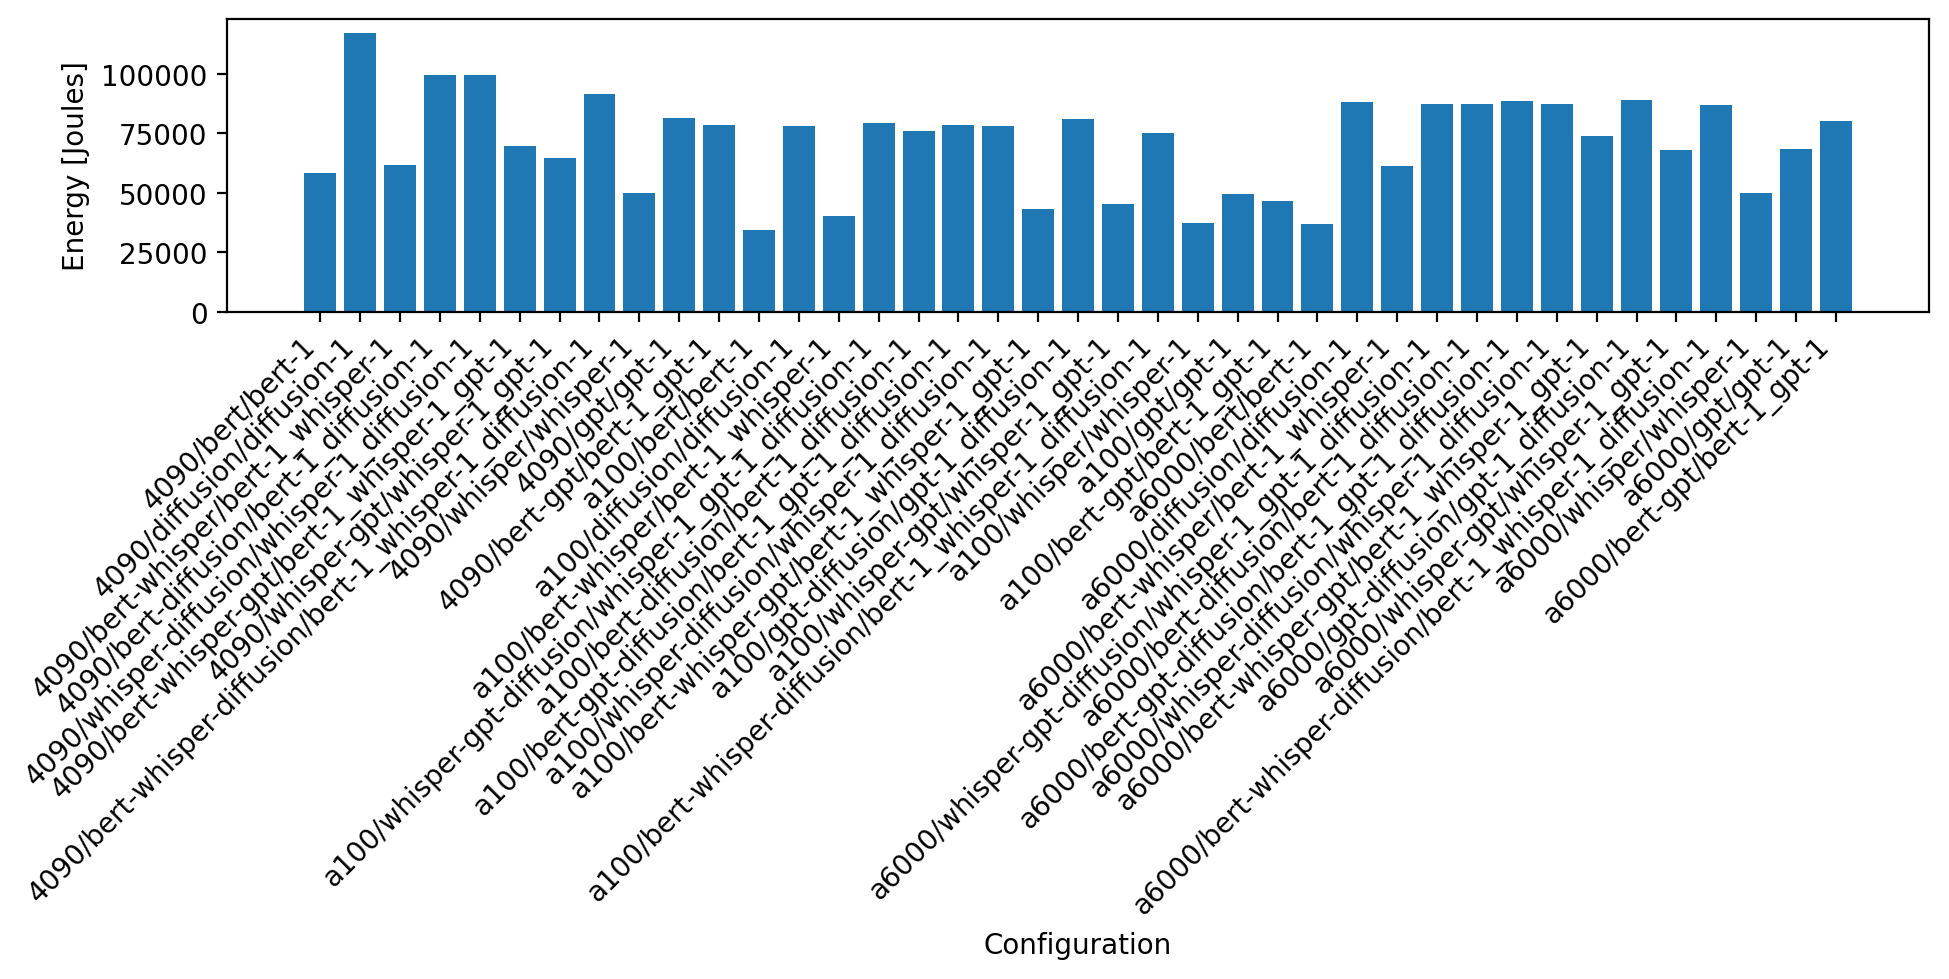

In [3]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=200)
ax.bar(dataset['configuration'], dataset['energy'])
ax.set_ylabel('Energy [Joules]')
ax.set_xlabel('Configuration')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

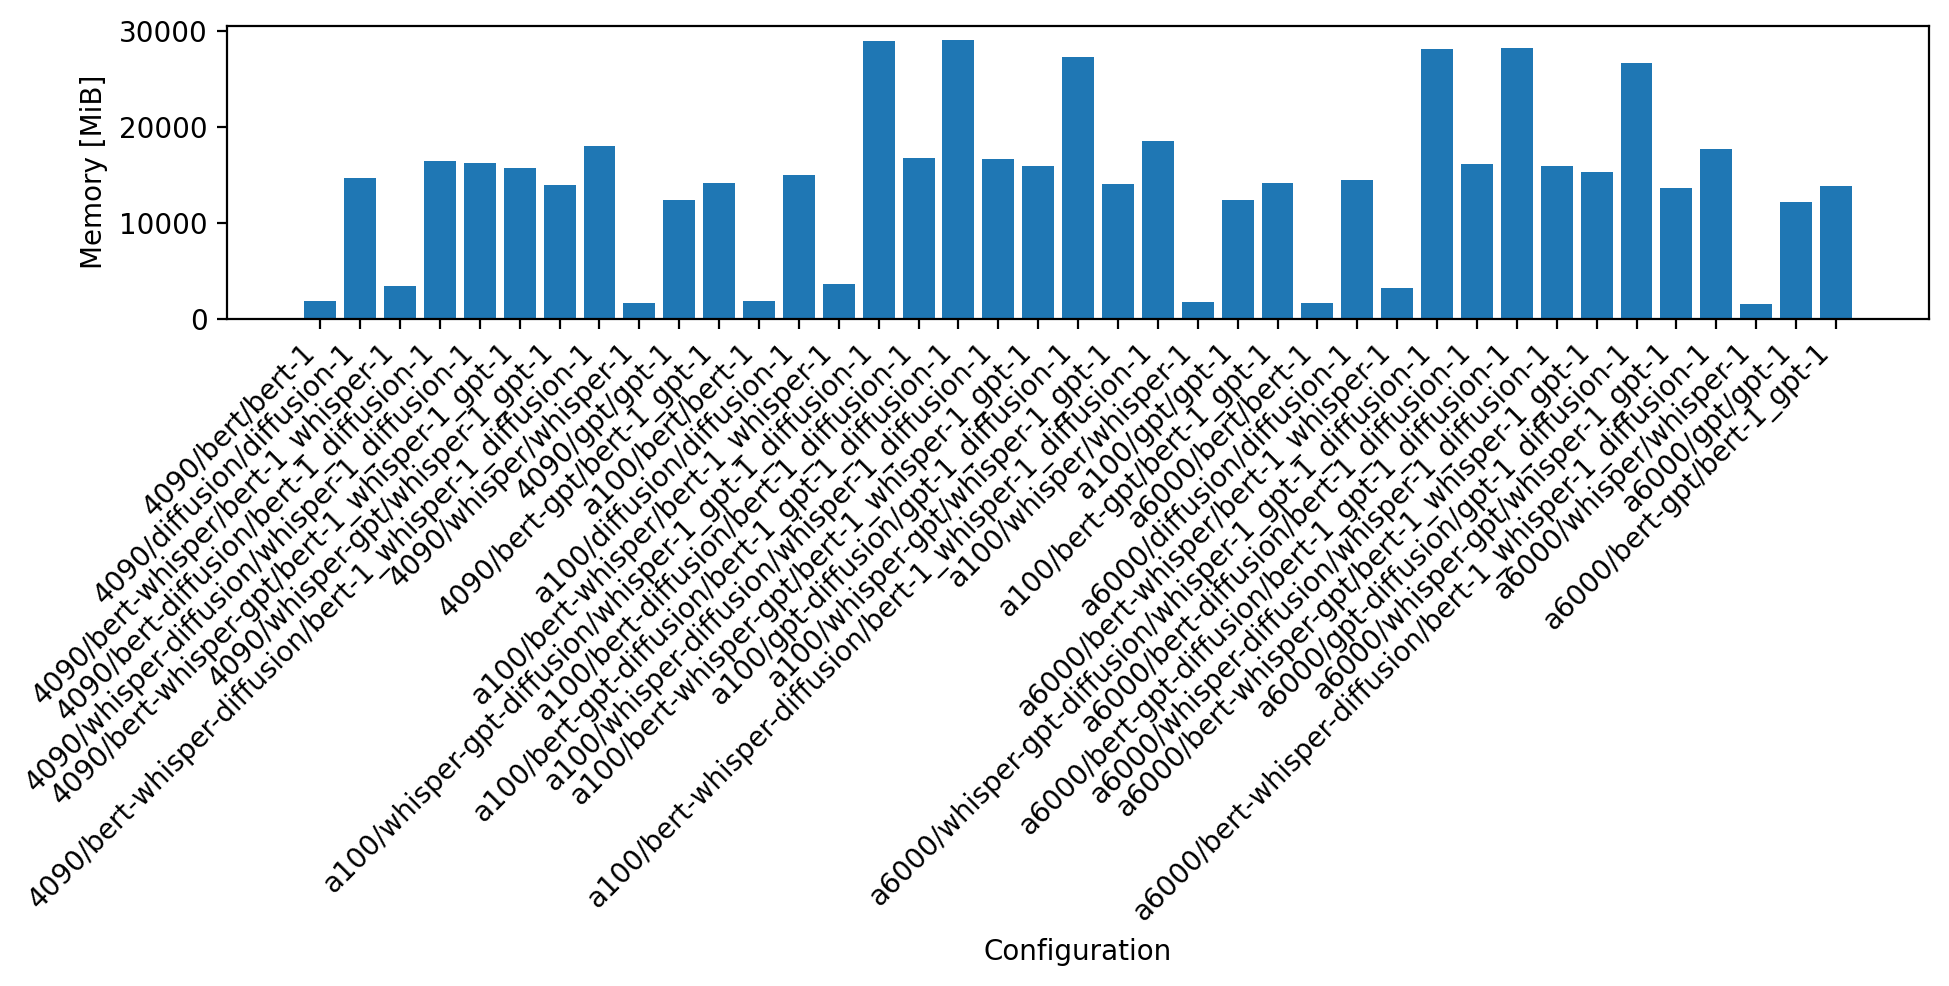

In [4]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=200)
ax.bar(dataset['configuration'], dataset['memory_MiB'])
ax.set_ylabel('Memory [MiB]')
ax.set_xlabel('Configuration')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

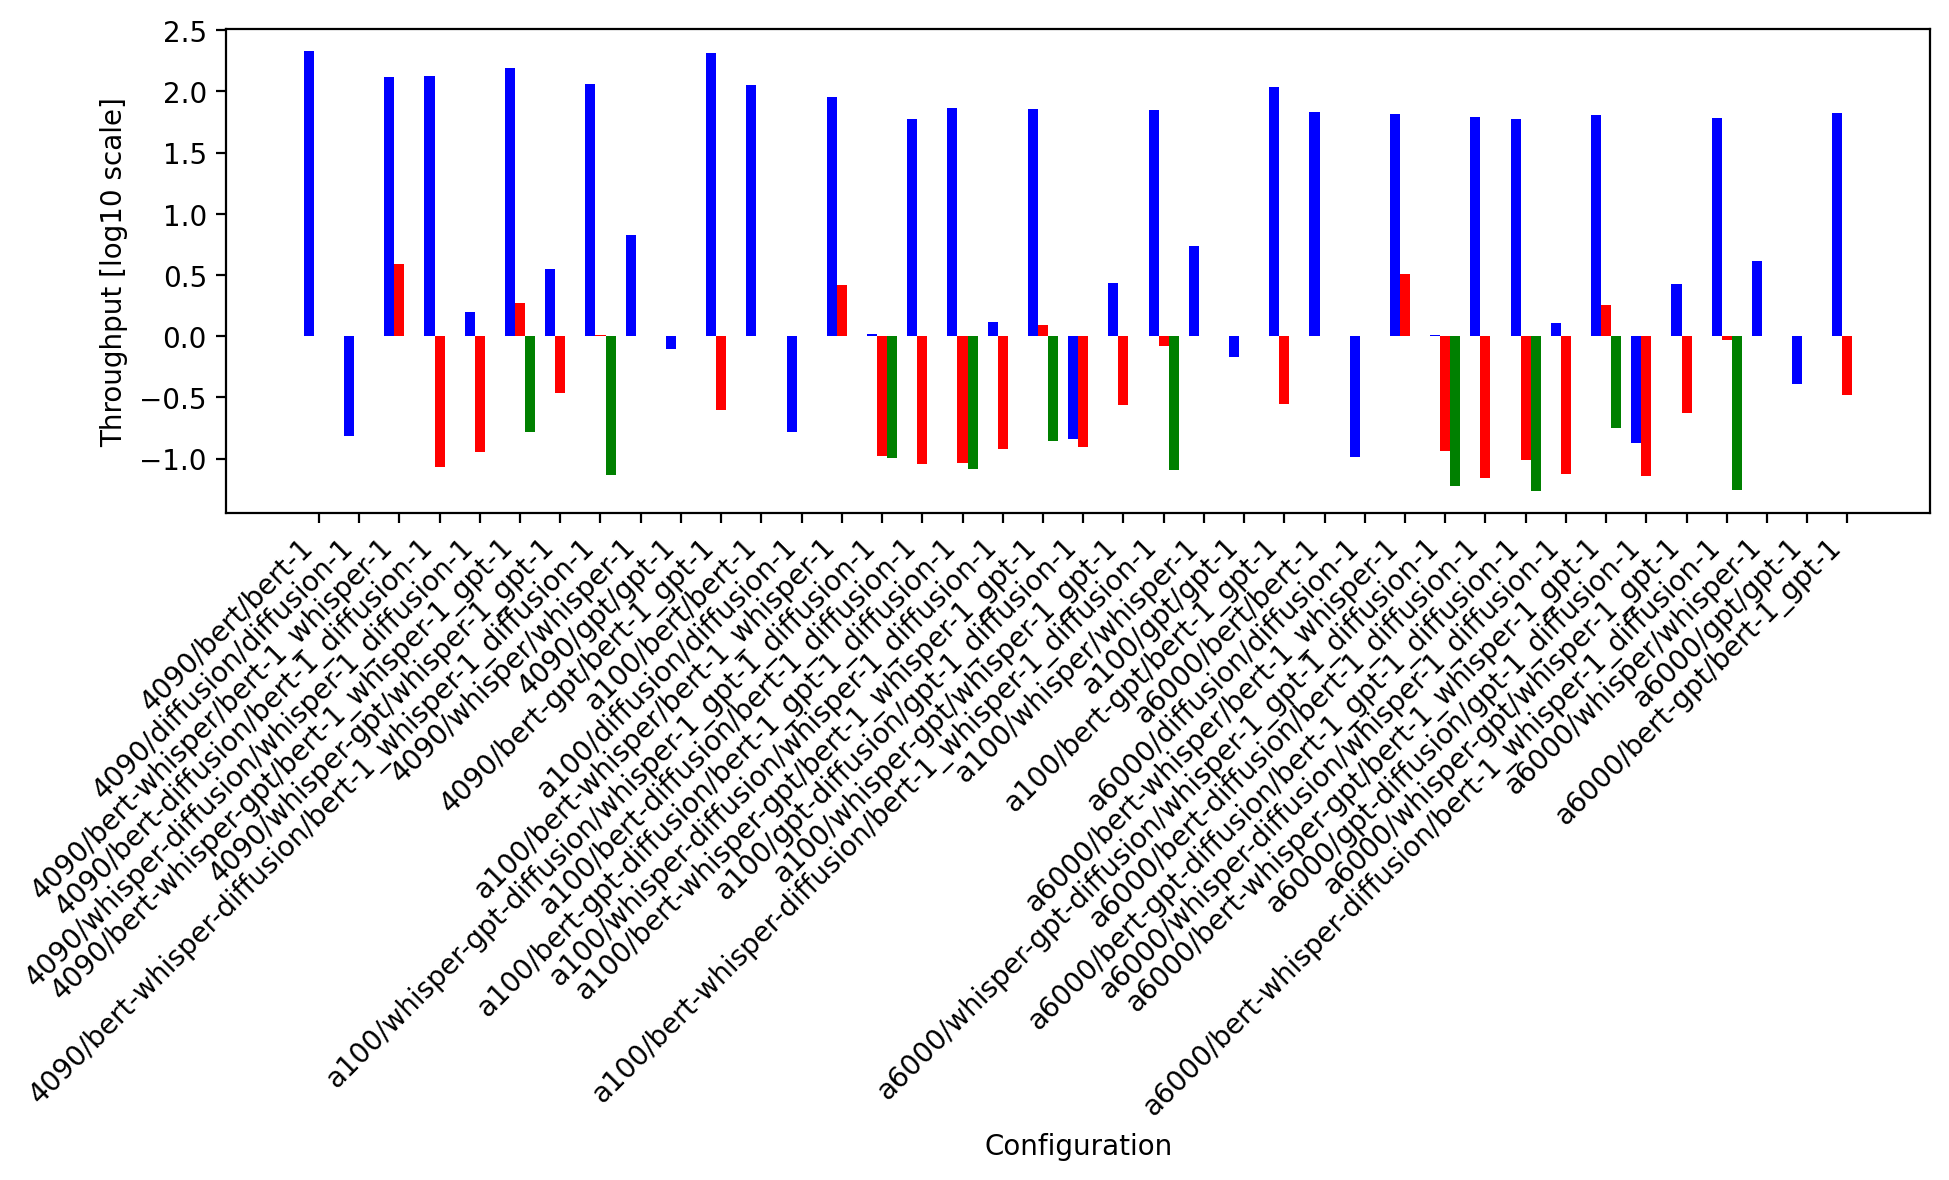

In [5]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=200)
width = 0.25 
x = np.arange(len(dataset['configuration']))
ax.bar(x - width, np.log10(dataset['throughput'][:, 0]), width, label='First model', color='blue')
ax.bar(x, np.log10(dataset['throughput'][:, 1]), width, label='Second model', color='red')
ax.bar(x + width, np.log10(dataset['throughput'][:, 2]), width, label='Third model', color='green')
ax.set_ylabel('Throughput [log10 scale]')
ax.set_xlabel('Configuration')
ax.set_xticks(x)
ax.set_xticklabels(dataset['configuration'])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()